In [11]:
# Importing the required libraries
import pandas  as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas_datareader as web
import datetime as dt 
# !pip install yfinance
import yfinance as yf
# !pip install sktime
import sktime
import pandas_datareader.data as pdr
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from tensorflow.keras.layers import Dense, Dropout, LSTM, LayerNormalization,Activation, BatchNormalization
from tensorflow.keras.models import Sequential
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras import backend
from sklearn.metrics import mean_squared_error
# from pycaret.regression import *

In [12]:
crypto_currency = 'BTC'
against_currency ='USD'
start = dt.datetime(2020,1,1)
end = dt.datetime.now()

In [13]:
yf.pdr_override()
data = pdr.get_data_yahoo("BTC-USD", start, end)

[*********************100%***********************]  1 of 1 completed


In [14]:
final_data = pd.DataFrame()
# final_data["Close_Open"] = np.power(data['Close']-data['Open'],3)
# final_data["High_Low"] = data['High']/data['Low']
# final_data['t1'] = (np.power(data["High"]-data["Low"],3))
final_data['Close'] = data['Close']
store = final_data
# final_data = pd.DataFrame(difference((final_data)))
final_data.head()
# scaler = PowerTransformer(method="yeo-johnson", standardize=True)
# scaler = MinMaxScaler(feature_range=(-1,1))
# scaler_close = MinMaxScaler(feature_range=(0,1))
# scaled_data = scaler.fit_transform(final_data.iloc[:,:3])
# scaled_close = scaler_close.fit_transform(final_data.iloc[:,3:4])
# scaled_data = np.concatenate((scaled_data,scaled_close),axis=1)
# logged_data = np.log10(data['Close'])
# scaled_data, lambda_data = (boxcox(data['Close']))#difference(logged_data).to_numpy()
# new = difference((data['Close'],1)
# scaled_data = pd.Series(scaled_data)

,Close
Date,
2019-12-31,7193.599121
2020-01-01,7200.174316
2020-01-02,6985.470215
2020-01-03,7344.884277
2020-01-04,7410.656738


In [15]:
# Preparing the Data
prediction_days = 200
future_days=0
# store = scaled_data
# scaled_data = np.array(difference(scaled_data))
x_train, y_train = [], []
scaled_data=np.array(final_data)
for x in range(prediction_days, len(scaled_data)-future_days-prediction_days-122):
    x_train.append(scaled_data[x-prediction_days:x])
    y_train.append(scaled_data[x+future_days:x+1,scaled_data.shape[1]-1])
x_train, y_train = np.array(x_train), np.array(y_train)
# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
# y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1],1))
# range(prediction_days, len(scaled_data))x_train
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1])
y_train = y_train.flatten()

In [16]:
x_train.shape

(453, 200)

In [17]:
import xgboost as xgb

In [18]:
model = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1)

In [19]:
model.fit(x_train, y_train, verbose=True)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=6,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [20]:

y_pred = []
y_ptrain=[]
for i in range(0,122):
    x_train, y_train = [], []
    scaled_data=np.array(final_data)
    for x in range(prediction_days, len(scaled_data)-future_days-prediction_days-122):
        x_train.append(scaled_data[x-prediction_days:x])
        y_train.append(scaled_data[x+future_days+i:x+1+i,scaled_data.shape[1]-1])
    x_train, y_train = np.array(x_train), np.array(y_train)
    # x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
    # y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1],1))
    # range(prediction_days, len(scaled_data))x_train
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1])
    y_train = y_train.flatten()
    
    model = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=1000, learning_rate=0.3,n_jobs=-1,max_depth=8)
    model.fit(x_train, y_train, verbose=True)
    x_test = scaled_data[-prediction_days-122:-122]
    x_test = x_test.reshape(1,x_test.shape[0])
    y_pred = y_pred + [model.predict(x_test)]
    y_ptrain = y_ptrain + [model.predict(x_train)]


Text(0.5, 1.0, 'Predicted vs Actual Close Prices (XGBoost)')

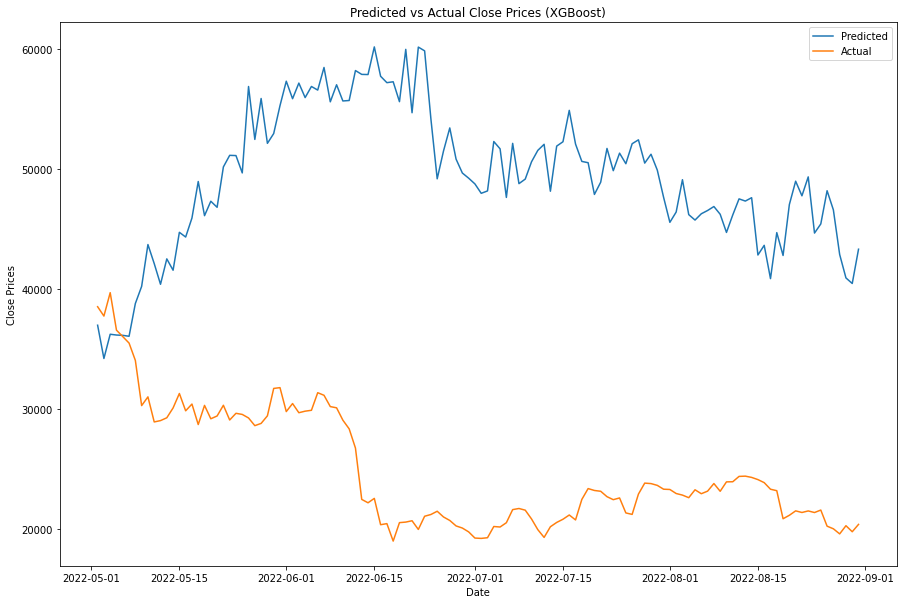

In [21]:
fig,axs = plt.subplots(1,1,figsize=(15,10))
axs.plot(final_data.index[-122:],y_pred)
axs.plot(final_data['Close'][-122:])
plt.legend(['Predicted','Actual'])
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.title('Predicted vs Actual Close Prices (XGBoost)')

In [155]:
y_ptrain = np.array(y_ptrain)
y_ptrain

array([[ 17.126822,  17.955458,  17.484774, ..., 419.10233 , 421.54944 ,
        405.06915 ],
       [ 17.955412,  17.485205,  17.71543 , ..., 421.54932 , 405.0697  ,
        413.45602 ],
       [ 17.484938,  17.715553,  18.091991, ..., 405.06918 , 413.45682 ,
        443.86737 ],
       ...,
       [ 27.935825,  27.62126 ,  28.06389 , ..., 399.02933 , 414.20044 ,
        419.54575 ],
       [ 27.621094,  28.064465,  28.529974, ..., 414.19974 , 419.54608 ,
        433.2292  ],
       [ 28.06453 ,  28.530214,  28.076117, ..., 419.5451  , 433.22845 ,
        408.77692 ]], dtype=float32)

In [156]:
y_ptrain[:,0].shape

(122,)

Text(0.5, 1.0, 'Predicted vs Actual Close Prices (XGBoost)')

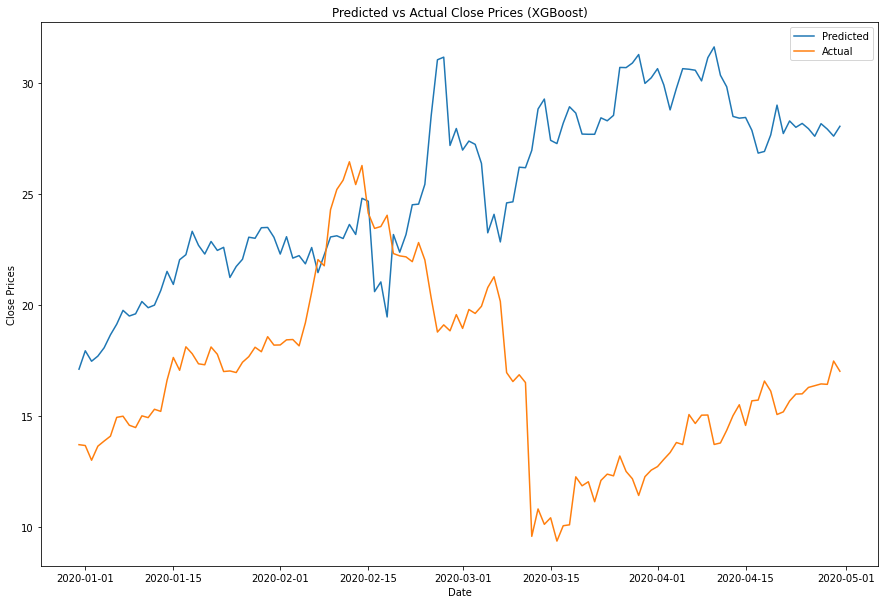

In [157]:
fig,axs = plt.subplots(1,1,figsize=(15,10))
axs.plot(final_data.index[:122],y_ptrain[:,0])
axs.plot(final_data['Close'][:122])
plt.legend(['Predicted','Actual'])
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.title('Predicted vs Actual Close Prices (XGBoost)')

In [158]:
def rmse(y_true, y_pred):
	return np.sqrt(np.mean(np.square(y_pred - y_true)))
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [159]:
rmse(final_data['Close'][-122:].values,y_pred[:])

101.49995936482716

In [160]:
mean_absolute_percentage_error(final_data['Close'][-122:].values,y_pred[:])

33.40368525796645

In [153]:
from sklearn.svm import SVR

In [154]:

y_pred = []
for i in range(0,122):
    x_train, y_train = [], []
    scaled_data=np.array(final_data)
    for x in range(prediction_days, len(scaled_data)-future_days-prediction_days-122):
        x_train.append(scaled_data[x-prediction_days:x])
        y_train.append(scaled_data[x+future_days+i:x+1+i,scaled_data.shape[1]-1])
    x_train, y_train = np.array(x_train), np.array(y_train)
    # x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
    # y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1],1))
    # range(prediction_days, len(scaled_data))x_train
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1])
    y_train = y_train.flatten()
    
    model = SVR()#.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1)
    model.fit(x_train, y_train)
    x_test = scaled_data[-prediction_days-122:-122]
    x_test = x_test.reshape(1,x_test.shape[0])
    y_pred = y_pred + [model.predict(x_test)]


Text(0.5, 1.0, 'Predicted vs Actual Close Prices (SVR)')

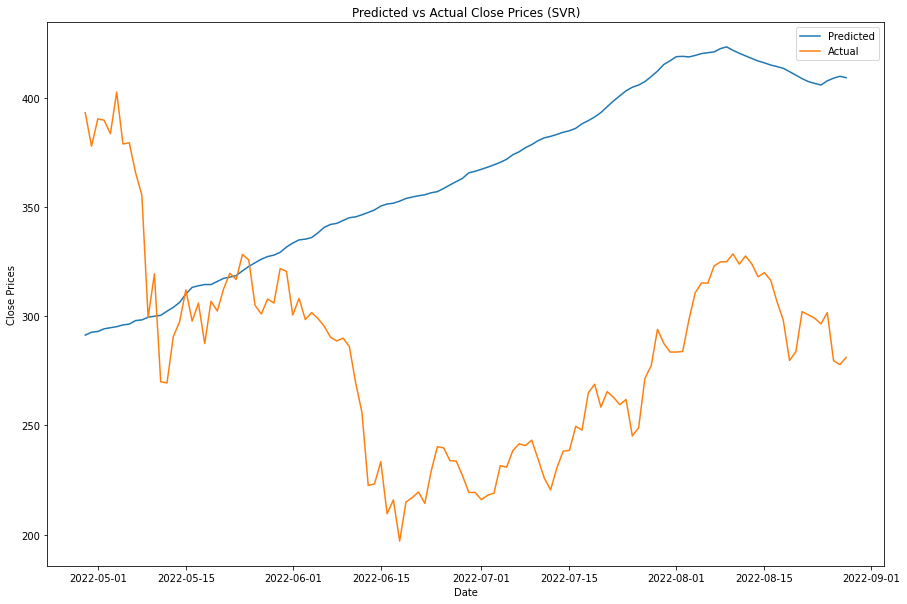

In [119]:
fig,axs = plt.subplots(1,1,figsize=(15,10))
axs.plot(final_data.index[-122:],y_pred)
axs.plot(final_data['Close'][-122:])
plt.legend(['Predicted','Actual'])
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.title('Predicted vs Actual Close Prices (SVR)')

In [120]:
rmse(final_data['Close'][-122:].values,y_pred[:])

101.49995936482716

In [121]:
mean_absolute_percentage_error(final_data['Close'][-122:].values,y_pred[:])

33.40368525796645